In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
trainset = torchvision.datasets.MNIST(root='./MNIST_train', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./MNIST_test', train=False, download=True)

In [3]:
def preprocess(image, label):
    imgArray = np.array(image)
    imgArray = np.float32(imgArray) / 255
    imgArray = imgArray.reshape(784)
    
    labVector = np.zeros(10)
    labVector[label] = 1
    
    return imgArray, labVector

In [4]:
def convertDatasetToNpArray(dataset):
    X = []
    Y = []
    for content in dataset:
        img, lab = preprocess(content[0], content[1])
        X.append(img)
        Y.append(lab)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [5]:
trainX, trainY = convertDatasetToNpArray(trainset)
testX, testY = convertDatasetToNpArray(testset)

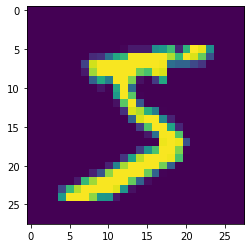

In [6]:
plt.imshow(trainX[0].reshape(28,28))

In [7]:
trainY[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

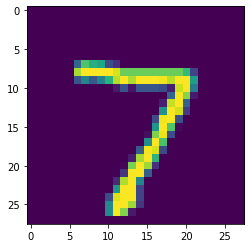

In [8]:
plt.imshow(testX[0].reshape(28,28))

In [9]:
testY[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [36]:
class Net():
    def __init__(self, lr=0.09, batch=20):
        self.lr = lr
        self.batch = batch
        self.hiddenWeights = 2 * np.random.rand(784, 64) - 1
        self.outputWeights = 2 * np.random.rand(64, 10) - 1
        self.hiddenSum = 0
        self.hiddenOut = np.random.rand(batch, 64)
        self.outputSum = 0
        self.outputOut = np.random.rand(batch, 10)
        
    def sigmod(self, x, derive=False):
        if derive is True:
            return x * (1 - x)
        return 1 / (1 + np.exp(-1 * x))
    
    def softmax(self, x):
        x = x - x.max(axis=1)[:,np.newaxis]
        exp = np.exp(x)
        exp_sum = np.sum(exp, axis=1)
        exp_sum = exp_sum[:,np.newaxis]
        return exp / exp_sum
    #
    # Output layer:
    # Think of the output layer as vector-matrix multiplication 
    # 
    # (out_h * W)
    # out_h are row vectors with shape (batchsize=1 or 20, 64) 
    # W is weight matrix with shape (64, 10)
    # After multiplication, we get socre vector with shape (batchsize, 10) 
    # softmax(out_h) returns row vectors with the same shape (batchsize, 10)


    # dW_hm = lr * delta_m * out_h
    # dW_gh = lr * delta_h * out_g
    # delta_m = (yhat - y_m) * f'(net) ----- y_m = f(net)
    # f'(net) of softmax is also a matrix, so called Jaccobian Matrix
    # f'(net) can be calculate based on the output of y_m
    # For each data, we compute a Jaccobian, 
    # for 20 data in a batch, we compute a list containing 20 Jaccobians
    # for more details:
    # https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/

    def derivative_softmax(self, x):
        Jaccobian_list = []
        softmax = self.softmax(x)        
        for row in softmax:
            diag = np.diag(row)
            row = row[np.newaxis,:]
            Jaccobian = diag - np.dot(row.T, row)
            Jaccobian_list.append(Jaccobian)
        return np.array(Jaccobian_list)

    # delta_m = (yhat - y_m) * f'(net) ----- y_m = f(net), net = dot(x, W)
    # for each neuron in the output layer, we need a delta value
    # for each input data, we get a delta vector
    # a delta vector can be computed by loss vector (yhat - y_m) * Jaccobian
     
    def delta_softmax(self, out, loss):
        delta_list = []
        Jaccobians = self.derivative_softmax(out)
        for idx, val in enumerate(loss):
            delta_list.append(np.dot(val, Jaccobians[idx]))
        return np.array(delta_list)
    
    def forward(self, x):
        self.hiddenSum = np.dot(x, self.hiddenWeights)
        self.hiddenOut = self.sigmod(self.hiddenSum)
        self.outputSum = np.dot(self.hiddenOut, self.outputWeights)
        self.outputOut = self.softmax(self.outputSum)
        return self.outputOut
    
    def backward(self, Input, loss):       
        outputDelta = self.delta_softmax(self.outputOut, loss)
        hiddenDelta = self.sigmod(self.hiddenOut, derive=True) * np.dot(outputDelta, self.outputWeights.T) 
        self.outputWeights += self.lr * np.dot(self.hiddenOut.T, outputDelta)
        self.hiddenWeights += self.lr * np.dot(Input.T, hiddenDelta)
        

In [60]:
testNet = Net(batch=2)
out = testNet.forward(trainX[0:2])
loss = MSEloss(trainY[0:2], out, derivate=True)
ds = testNet.derivative_softmax(out)
delta_m = testNet.delta_softmax(out, loss)

In [68]:
print(out.shape)
print(loss.shape)
print(ds.shape)
print(delta_m.shape)
print(testNet.outputWeights.shape)
print(testNet.hiddenOut.T.shape)
print(np.dot(testNet.hiddenOut.T, delta_m).shape)

(2, 10)
(2, 10)
(2, 10, 10)
(2, 10)
(64, 10)
(64, 2)
(64, 10)


In [37]:
net = Net()

In [12]:
def MSEloss(labels, outputs, derivate = False):
    if derivate is True:
        return labels - outputs
    
    loss = 1.0 / 2.0 * np.sum((labels - outputs)**2)
    return loss

In [13]:
class DataLoader():
    def __init__(self, dataX, dataY, batch=20, shuffle=True):
        self.dataX = dataX
        self.dataY = dataY
        self.batch = batch
        self.startIdx = 0
        self.current = 1
        self.len = len(dataY)
        self.shuffle = shuffle
    
    def shuffle(self, seed=1):
        np.random.seed(seed)    
        np.random.shuffle(self.dataX)
        np.random.seed(seed)
        np.random.shuffle(self.dataY)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        
        endIdx = self.current * self.batch
        if endIdx > self.len:
            currentX = self.dataX[self.startIdx:]
            currentY = self.dataY[self.startIdx:]
            self.startIdx = 0
            self.current = 1
            if self.shuffle is True: DataLoader.shuffle(self)
            raise StopIteration
        else:    
            currentX = self.dataX[self.startIdx:endIdx]
            currentY = self.dataY[self.startIdx:endIdx]
            self.current += 1
            self.startIdx = endIdx
        
        return currentX, currentY

In [14]:
def train(dataloader, model, epoch=50):
    for i in range(epoch):
        for data, labels in dataloader:
            out = model.forward(data)
            loss = MSEloss(labels, out)
            model.backward(data, MSEloss(labels, out, derivate=True))
        if i % 10 == 0: print(loss)

In [15]:
trainloader = DataLoader(trainX, trainY)

In [38]:
train(trainloader, net)

2.019548653500467
0.2046615674103025
0.008080536844830942
0.30441630900060596
0.0012545042335592722


In [39]:
out = net.forward(testX[50:80])
print('predict: ', np.argmax(out,axis=1))
print('labels : ', np.argmax(testY[50:80],axis=1))

predict:  [6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7]
labels :  [6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7]


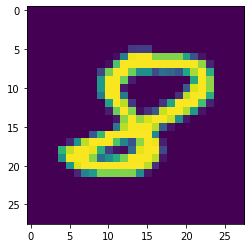

In [ ]:
plt.imshow(testX[61].reshape(28,28))